In [1]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
n_class = 10
covs = []
dim = 2
np.random.seed(0)
for _ in range(n_class):
    matrixSize = 2
    A = np.random.rand(dim, dim) * 2
    B = np.dot(A, A.transpose())
    covs.append(B)
gaussians = [MultivariateNormal(torch.zeros(2), torch.from_numpy(cov).to(torch.float)) for cov in covs]

In [3]:
def create_dataset(gaussians, n_sample):
    torch.manual_seed(0)
    random.seed(0)

    data = []
    labels = []
    for label, g in enumerate(gaussians):
        for n in range(n_sample):
            n_element = random.randint(160, 200)
            data.append(g.sample((n_element, )).numpy())
            labels.append(label)
    return data, np.array(labels)

In [4]:
n_train = 80
n_test = 20

x_train, y_train = create_dataset(gaussians, n_train)
x_test, y_test = create_dataset(gaussians, n_test)

data = {'x_train': x_train, 'y_train': y_train, 'x_test': x_test, 'y_test': y_test}

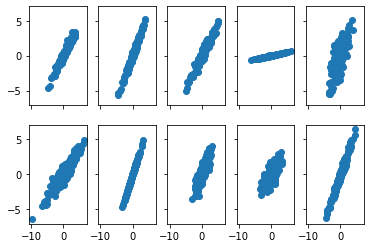

In [5]:
n_col = 5
n_row = 2
fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True)
for i in range(n_class):
    r = i // n_col
    c = i % n_col
    
    ax[r, c].scatter(x_train[i * n_train][:, 0], x_train[i * n_train][:, 1])
plt.show()

In [6]:
def compute_matrix_square_root(m):
    # compute eigendecomposition of m
    evals, evecs = torch.linalg.eig(m)

    # get real part of eigen values and eigen vectors
    evals = evals.real
    evecs = evecs.real

    # compute the square root of a diagonal matrix whose diagonals are (positive) eigen values
    diag_mat_sqrt = torch.diag(torch.sqrt(evals))

    return evecs @ diag_mat_sqrt @ torch.inverse(evecs)


def bures_wasserstein_for_gaussian(g1_mean, g1_cov, g2_mean, g2_cov):
    g1_cov_mat_sqrt = compute_matrix_square_root(g1_cov)
    trace = (g1_cov + g2_cov - 2 * compute_matrix_square_root(g1_cov_mat_sqrt @ g2_cov @ g1_cov_mat_sqrt)).trace()
    return ((g1_mean - g2_mean) ** 2).sum() + trace

In [7]:
dist_matrix = torch.zeros((n_test * n_class, n_train * n_class))
for i, test_sample in enumerate(x_test):
    for j, train_sample in enumerate(x_train):
        test_mu = torch.from_numpy(test_sample.mean(0))
        test_cov = torch.from_numpy(np.cov(test_sample.T))
        
        train_mu = torch.from_numpy(train_sample.mean(0))
        train_cov = torch.from_numpy(np.cov(train_sample.T))

        dist = bures_wasserstein_for_gaussian(test_mu, test_cov, train_mu, train_cov).item()
        dist_matrix[i, j] = dist

In [8]:
sorted_mat, inds = torch.sort(dist_matrix, dim=1)

In [9]:
inds[:, 0]

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  88, 122,  86,  87, 107, 109,  81, 145,
        111, 129,  87, 123, 140, 124, 141,  98, 141, 111, 111, 146, 236, 206,
        227, 180, 194, 179, 215, 163, 170, 166, 233, 170, 168, 174, 179, 232,
        214, 208, 215, 233, 246, 251, 297, 297, 269, 308, 308, 265, 258, 290,
        247, 309, 276, 274, 244, 257, 250, 291, 273, 252, 359, 376, 350, 385,
        398, 386, 331, 351, 325, 398, 376, 345, 365, 336, 375, 377, 388, 388,
        354, 398, 455, 474, 465, 473, 471, 433, 400, 419, 448, 421, 467, 444,
        420, 472, 464, 467, 464, 460, 433, 462, 514, 495, 542, 539, 500, 515,
        558, 522, 531, 515, 507, 487, 548, 556, 554, 514, 513, 497, 492, 497,
        566, 580, 592, 595, 614, 569, 626, 628, 625, 625, 565, 617, 591, 572,
        568, 581, 626, 576, 583, 623, 662, 676, 667, 701, 645, 700, 696, 674,
        648, 669, 646, 704, 680, 690, 708, 671, 714, 678, 674, 6

In [10]:
import pickle

In [11]:
with open('../dataset/gaussians/nn_gts.pickle', 'wb') as handle:
    pickle.dump(inds[:, 0], handle)

In [12]:
with open('../dataset/gaussians/data.pickle', 'wb') as handle:
    pickle.dump(data, handle)

In [13]:
with open('../dataset/gaussians/data.pickle', 'rb') as handle:
    data = pickle.load(handle)